In [1]:
%load_ext autoreload
%autoreload 2

import ncem
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

datadir = '.'

In [2]:
ad = sc.read(datadir + 'destvi_lymphnode/destVI_lymphnode.h5ad')

cell_names = list(ad.uns['node_type_names'].values())
h_0 = pd.DataFrame(ad.obsm['node_types'], columns=cell_names)
target_type = pd.DataFrame(np.array(h_0.idxmax(axis=1)), columns=["target_cell"]).reset_index()
ad.obs = target_type

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'target_cell' as categorical


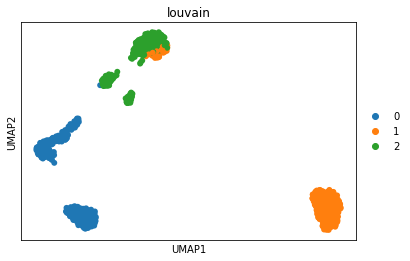

In [3]:
ad_subset = ad[ad.obs['target_cell'] == 'B cells']
sc.pp.neighbors(ad_subset, n_neighbors=300, n_pcs=50)
sc.tl.louvain(ad_subset)
sc.tl.umap(ad_subset)
sc.pl.umap(ad_subset, color='louvain')

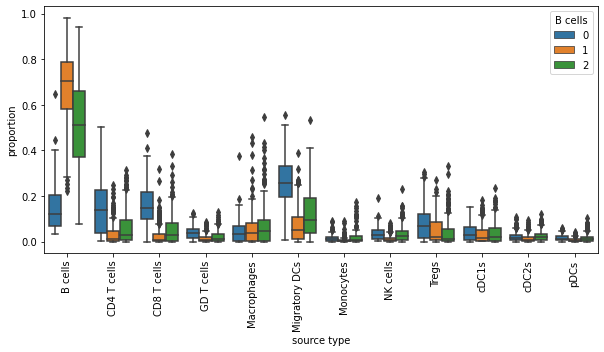

In [4]:
df_list = []
plt.rcParams['axes.grid'] = False
for clust in np.unique(ad_subset.obs['louvain']):
    temp = ad_subset[ad_subset.obs['louvain'] == clust].obsm['proportions']
    temp_df = pd.DataFrame(pd.DataFrame(temp, columns=cell_names).stack().reset_index()).rename(
        columns={'level_0': 'index', 'level_1': 'source type', 0: 'proportion'})
    temp_df['B cells'] = clust
    df_list.append(temp_df)
    
data = pd.concat(df_list, axis=0)
plt.ioff()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8.5,5))
sns.boxplot(data=data, x='source type', y ='proportion', hue='B cells', ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

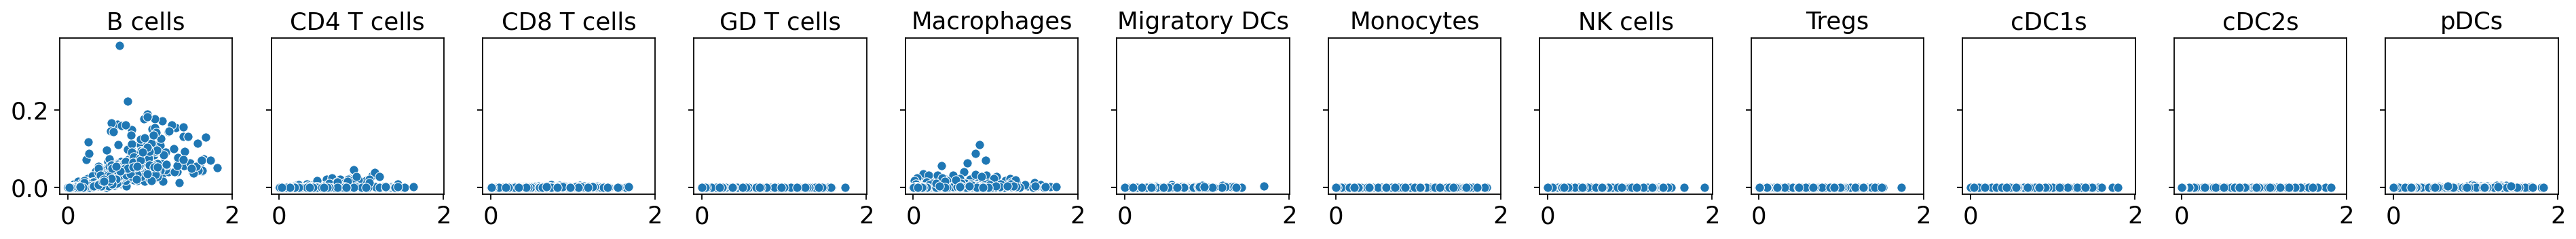

In [5]:
plt.ioff()
ct = np.unique(ad.obs['target_cell'])
sc.set_figure_params(scanpy=True, fontsize=16)
nrows = len(ct) // 12 + int(len(ct) % 12 > 0)
fig, ax = plt.subplots(
    ncols=12, nrows=nrows, figsize=(12 * 2, nrows *2.5), sharex="all", sharey="all"
)
ax = ax.flat
for axis in ax[len(ct) :]:
    axis.remove()
variance_mean = []
for i, ci in enumerate(ct):
    x=np.array(np.log(ad[ad.obs['target_cell']==ci].X.mean(axis=0)+1)).squeeze()
    y=np.array(np.log(ad[ad.obs['target_cell']==ci].X.var(axis=0)+1)).squeeze()
    sns.scatterplot(x=x, y=y, ax=ax[i])
    variance_mean.append(np.array(y/x))
    ax[i].grid(False)
    ax[i].set_title(ci, fontsize=16)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
# Save, show and return figure.
plt.tight_layout()
plt.show()